In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
    
import sys
p = '/home/qnicolas/stationaryWave/'
if p not in sys.path:
    sys.path.append(p)
from mydedalustools import *    

%load_ext autoreload
%autoreload 2

SNAPSHOTS_DIR = "/net/helium/atmosdyn/qnicolas/stationarywave_snapshots/"

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


[iacdipl-6:06080] pml_ucx.c:313  Error: Failed to create UCP worker


[1750776483.841193] [iacdipl-6:6080 :0]           ib_md.c:282  UCX  ERROR ibv_reg_mr(address=0x7f0949800000, length=39845888, access=0xf) failed: Cannot allocate memory : Please set max locked memory (ulimit -l) to 'unlimited' (current: 8192 kbytes)
[1750776483.841251] [iacdipl-6:6080 :0]           mpool.c:269  UCX  ERROR Failed to allocate memory pool (name=rc_recv_desc) chunk: Input/output error
[1750776483.846388] [iacdipl-6:6080 :0]         ib_mlx5.c:127  UCX  ERROR mlx5_bond_0: mlx5dv_create_cq(cqe=4096) failed: Cannot allocate memory : Please set max locked memory (ulimit -l) to 'unlimited' (current: 8192 kbytes)
[1750776483.846646] [iacdipl-6:6080 :0]      ucp_worker.c:1413 UCX  ERROR uct_iface_open(ud_mlx5/mlx5_bond_0:1) failed: Input/output error


This notebook presents a test of a 12-level sigma model: Gill pattern in the tropics.

# Gill pattern

In [2]:
snapshot_id = 'stationarywave_12level_T32_idealgill'
gill = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
gill = concat_levels(gill ,12)


## Heating pattern

Text(0.5, 1.0, 'Heating at mid levels (K/day)')

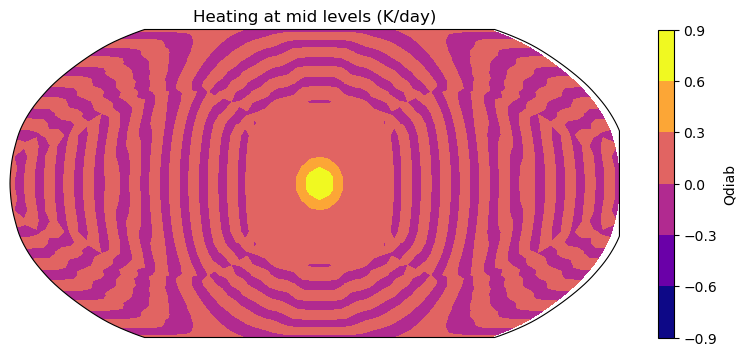

In [3]:
# Perturbation vorticity in rhs run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill.Qdiab.isel(t=0,sigma=5)).transpose().plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap=plt.cm.plasma)
plt.title('Heating at mid levels (K/day)')

In [4]:
qdiab = gill.Qdiab
def plot_heating(ax):
    (qdiab.isel(t=0,sigma=5)).plot.contour(ax=ax,levels=[0.4],colors='k',transform=ccrs.PlateCarree())

## Response

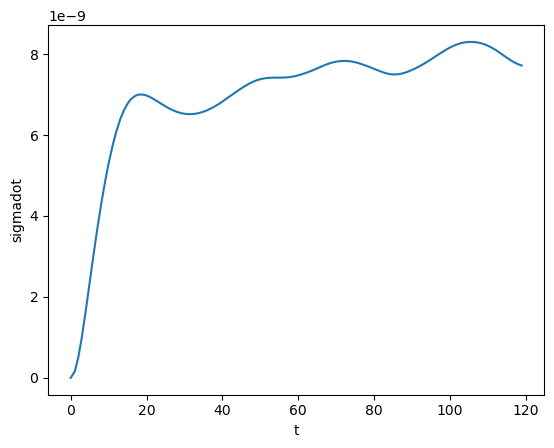

In [5]:
# CONVERGENCE
np.sqrt((gill.sigmadot**2).mean(('longitude','latitude','sigma_stag'))).plot()


In [6]:
gill_mean = gill.sel(t=slice(100,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')
# We calculate omega offline - a bug in Dedalus prevents us from calculating
# it during the run when using a zonally-symmetric basic state.
gill_mean['omega'] = calc_omega(gill_mean)

Text(0.5, 1.0, 'Perturbation vorticity at sigma=0.25 (s^-1)')

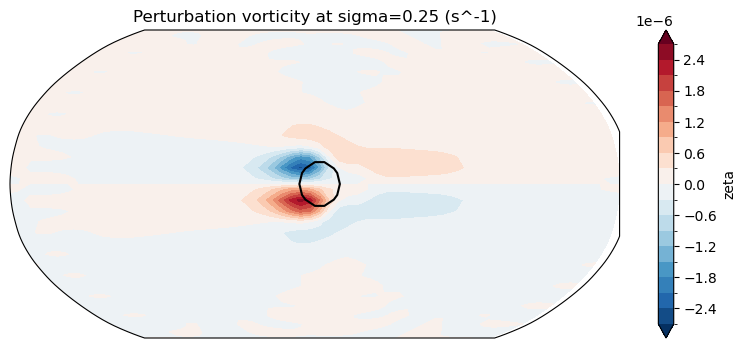

In [7]:
# Perturbation vorticity
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill_mean.zeta.sel(sigma=0.25,method='nearest')).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
plot_heating(ax)
plt.title('Perturbation vorticity at sigma=0.25 (s^-1)')

Text(0.5, 1.0, 'Perturbation surface pressure and wind at sigma=0.75 ')

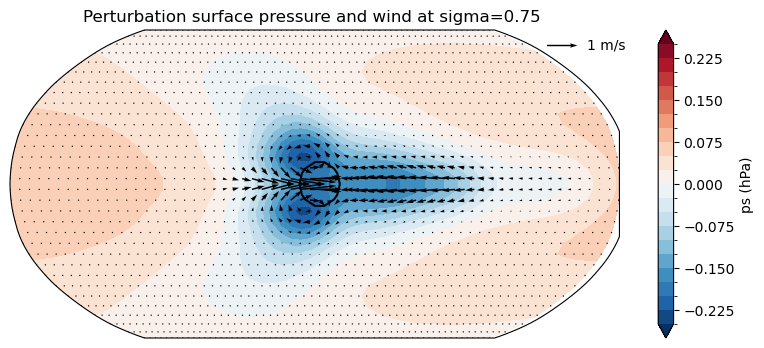

In [8]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(1e3 * gill_mean.lnps).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'ps (hPa)'})

plot_heating(ax)

u= (gill_mean.u[0].sel(sigma=0.75,method='nearest'))
v=-(gill_mean.u[1].sel(sigma=0.75,method='nearest'))
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=1;m=n
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=20,transform=ccrs.PlateCarree())
ax.quiverkey(Q, 0.93,0.95, 1., label='1 m/s', labelpos='E', coordinates='axes',color='k')

plt.title('Perturbation surface pressure and wind at sigma=0.75 ')

Text(0.5, 1.0, 'Perturbation pressure velocity (not sigma_dot) at sigma=0.5 ')

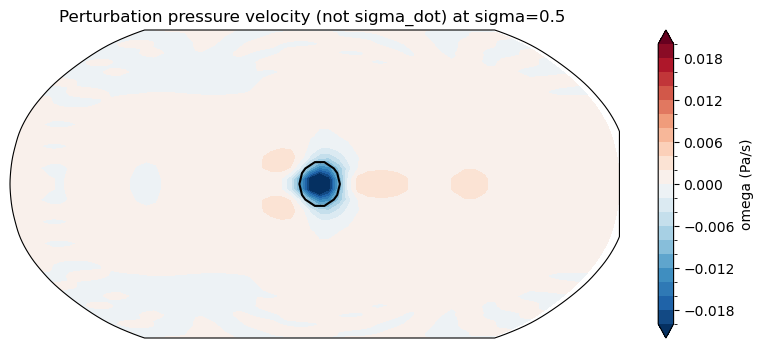

In [9]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})

(gill_mean.omega.sel(sigma_stag=0.5,method='nearest')).plot.contourf(ax=ax,levels=np.linspace(-1,1,21)/5e1,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'omega (Pa/s)'})

plot_heating(ax)

plt.title('Perturbation pressure velocity (not sigma_dot) at sigma=0.5 ')

## Comparing the RHS formulation

In [10]:
# The linear problem with zonally-symmetric basic state can be solved
# with advection terms treated either implicitly or explicitly.
# The rhs run uses the explicit advection, which is less costly 
# when building problem matrices, but more costly at runtime.
# Here, we compare the two solutions.

In [11]:
snapshot_id = 'stationarywave_12level_T32_idealgill_rhs'
gill_rhs = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
gill_rhs = concat_levels(gill_rhs ,12)
gill_rhs_mean = gill_rhs.sel(t=slice(100,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')


Text(0.5, 1.0, 'Perturbation surface pressure and wind at sigma=0.75 ')

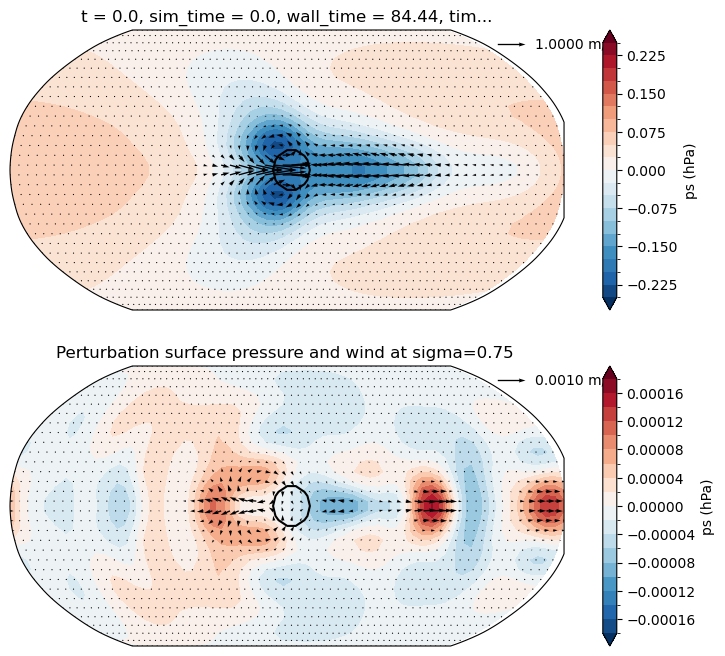

In [12]:
# Perturbation pressure (~p0 * lnps)
_,axs=plt.subplots(2,1,figsize=(10,8),subplot_kw={'projection':ccrs.Robinson()})

for ax,sim,sc in zip(axs,(gill_rhs_mean,gill_mean - gill_rhs_mean),(20,2e-2)):
    (1e3*sim.lnps).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'ps (hPa)'})
    
    u= (sim.u[0].sel(sigma=0.75,method='nearest'))
    v=-(sim.u[1].sel(sigma=0.75,method='nearest'))
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=1;m=n
    Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=sc,transform=ccrs.PlateCarree())
    ax.quiverkey(Q, 0.93,0.95, sc/20, label='%.4f m/s'%(sc/20), labelpos='E', coordinates='axes',color='k')

    plot_heating(ax)

plt.title('Perturbation surface pressure and wind at sigma=0.75 ')